---
title: "Training Resnet50 on Oxford Flowers"
date: 2025-04-28
slug: resnet-oxford-flowers
author: "Aaron James"
categories: [machine learning, fastai, computer-vision]
format:
  html:
    toc: true
    code-fold: true
---

# How I trained Resnet 50 on the Oxford Flowers Dataset

![oxford_flowers.jpg](oxford_flowers.jpg)

I'm applying to an AI fellowship, and this was their first test! I needed to use the resnet50 CNN model and fine tune it to be able to classify the flowers from the [Oxford Flowers](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) dataset. In this post, I detail how I was able to do this and beat the accuracy achieved by the authors of [the original paper](https://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/).

I've been working through fastai's course [Part 1](https://course.fast.ai/), so I'll be using their framework for this challenge. I also just finished the sixth lesson, which references Jeremy Howard's "[Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1)" series of kaggle notebooks. I'm mostly implementing the methodologies used in those notebooks on this dataset.

In [1]:
from fastai.imports import *
from fastai.vision.all import *
from fastai.data.all import *


# Read and Interpret Raw Data
The first thing I need to do is to understand what I've downloaded. The .readme file helps, but I want to make sure I understand how the dataset is constructed. I want to prepare to split the data into its splits as well (train, test, validation).


In [2]:
from scipy.io import loadmat

data_splits = loadmat('setid.mat')
data_splits

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

Ok that's great. I can see how the .mat file stores the ids for the splits and now I'll load them into memory and check if the splits make sense.

In [3]:
trn_idxs = data_splits['trnid'].squeeze()
val_idxs = data_splits['valid'].squeeze()
tst_idxs = data_splits['tstid'].squeeze()
len(trn_idxs), len(val_idxs), len(tst_idxs)


(1020, 1020, 6149)

I'm suprised by this breakdown. I would have expected most of the data to be in the training set, then the validation set, then the test set. Since there are ~100 categories, we really only have around 10 images per flower in our training set (I'm estimating). It seems like it would be fairly difficult for the model to generalize with this amount of data. 

Now we need the labels for each image loaded into memory. For this, I'll need to open another .mat file that contains them and analyze its contents.

In [4]:
from scipy.io import loadmat

image_labels = loadmat('imagelabels.mat')
image_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

Hm. I'm assuming that the index of the labels array corresponds to the number of the image in the original dataset. If the total number of indexes across all splits is exactly the same as the length of the labels array, I'll continue with this assumption.

In [5]:
labels = image_labels['labels'].squeeze()
assert(sum([len(trn_idxs), len(val_idxs), len(tst_idxs)]) == len(labels))

Ok, well there you go. 

# Execute Data Splits Computationally

I realized I could download the data from fastai directly, so let's do that. I'm assuming this means it'll be formatted in a more friendly manner.

In [6]:
path = untar_data(URLs.FLOWERS)
path.ls()

(#7) [Path('/home/aharon/.fastai/data/oxford-102-flowers/smaller'),Path('/home/aharon/.fastai/data/oxford-102-flowers/oxford_flower_102_name.csv'),Path('/home/aharon/.fastai/data/oxford-102-flowers/jpg'),Path('/home/aharon/.fastai/data/oxford-102-flowers/flower_final.pkl'),Path('/home/aharon/.fastai/data/oxford-102-flowers/train.txt'),Path('/home/aharon/.fastai/data/oxford-102-flowers/test.txt'),Path('/home/aharon/.fastai/data/oxford-102-flowers/valid.txt')]

This data is formatted slightly differently. The main difference is that now we have three text files that outline each data split, its filepaths, and their labels. The [fastai docs](https://docs.fast.ai/data.external.html) actually state that the downloaded dataset only has 17 categories. I want to confirm whether or not that is actually true so I can determine which format to use.

In [7]:
train_df = pd.read_csv(path/'train.txt', sep=' ', header=None, names=['fname', 'label'])
valid_df = pd.read_csv(path/'valid.txt', sep=' ', header=None, names=['fname', 'label'])
test_df = pd.read_csv(path/'test.txt', sep=' ', header=None, names=['fname', 'label'])

flower_categories = 102

# Does the dataset only have 17 categories or all 102?
assert(len(train_df.label.unique()) == flower_categories)
assert(len(train_df.label.unique()) == len(valid_df.label.unique()) == len(test_df.label.unique()))

# Are there the same number of pictures as before?
assert(len(train_df) + len(valid_df) + len(test_df) == len(labels))

# If both of these conditions are valid, display the head of the training data
train_df.head()


,fname,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


Fantastic! The fastai direct download for the flowers dataset actually does contain all 102 categories of images, and has the same number of images as the original link. 

Now we want to load the image data into a fastai structure called dataloaders. Very basically, we do this so that we can associate each image with a label, and so that we can transform the data more easily.

In [8]:
# Add a is_valid column so the dataloaders know which data belongs to the validation set
train_df['is_valid'] = False
valid_df['is_valid'] = True

#Ignore_index makes sure that the indices of the valid dataset continue after 1019 to 1020, and don't reset to 0, 1, etc.
trn_vld_df = pd.concat([train_df, valid_df], ignore_index=True)

trn_vld_df.head()

,fname,label,is_valid
0,jpg/image_03860.jpg,16,False
1,jpg/image_06092.jpg,13,False
2,jpg/image_02400.jpg,42,False
3,jpg/image_02852.jpg,55,False
4,jpg/image_07710.jpg,96,False


Before actually loading the data into the dataloaders, I want to see if I can get a sense of the sizes of the original images. This will help me understand what transforms to apply.

(667, 500)


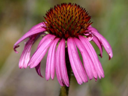

In [9]:
img = PILImage.create(path/"jpg/image_03860.jpg")
print(img.size)
img.to_thumb(128)


No fun. I'm assuming this means that the image sizes are all over the place. Let's see if we can get a good sense of the sizes of our training/validation set.

In [10]:
from fastcore.parallel import *

def f(o): return PILImage.create(path/o).size
trn_vld_df["dimensions"] = parallel(f, trn_vld_df.fname, n_workers=8)
trn_vld_df.head()

,fname,label,is_valid,dimensions
0,jpg/image_03860.jpg,16,False,"(667, 500)"
1,jpg/image_06092.jpg,13,False,"(500, 638)"
2,jpg/image_02400.jpg,42,False,"(500, 667)"
3,jpg/image_02852.jpg,55,False,"(656, 500)"
4,jpg/image_07710.jpg,96,False,"(500, 601)"


In [11]:
dim = trn_vld_df.dimensions[0]
trn_vld_df['width'] = trn_vld_df.dimensions.apply(lambda x: x[0])
trn_vld_df['height'] = trn_vld_df.dimensions.apply(lambda x: x[1])
trn_vld_df.height.describe(), trn_vld_df.width.describe()


(count    2040.000000
 mean      535.593627
 std        76.971209
 min       500.000000
 25%       500.000000
 50%       500.000000
 75%       501.000000
 max      1066.000000
 Name: height, dtype: float64,
 count    2040.000000
 mean      623.470588
 std        95.725085
 min       500.000000
 25%       500.000000
 50%       666.000000
 75%       680.000000
 max       919.000000
 Name: width, dtype: float64)

So I can see the minimum of each dimension is 500 pixels, so I'll squish the images to be 500x500 at least for now.

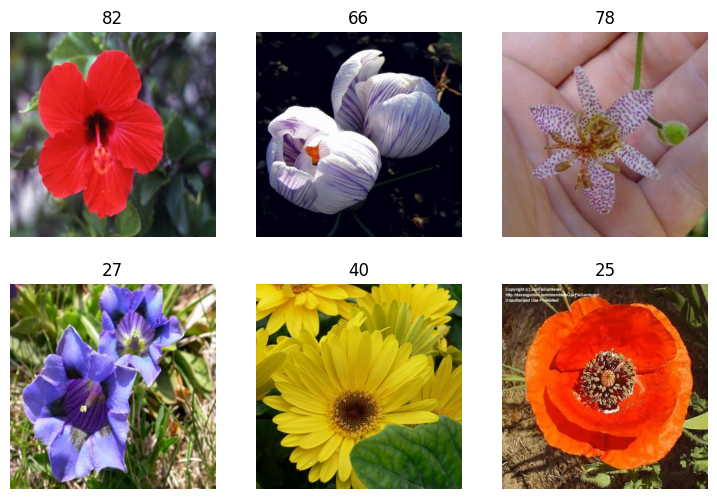

In [12]:
dls = ImageDataLoaders.from_df(
    trn_vld_df,
    path=path,
    folder='.',
    valid_col='is_valid',
    label_col='label',
    fn_col='fname',
    item_tfms=Resize(500, method="squish")
)

dls.show_batch(max_n=6)

Looking at this, I'd prefer that these flowers use the actual label names and not just the numbers. I downloaded the mapping from [this kaggle resource](https://www.kaggle.com/datasets/hobaak/oxford-102-flower-name-index)

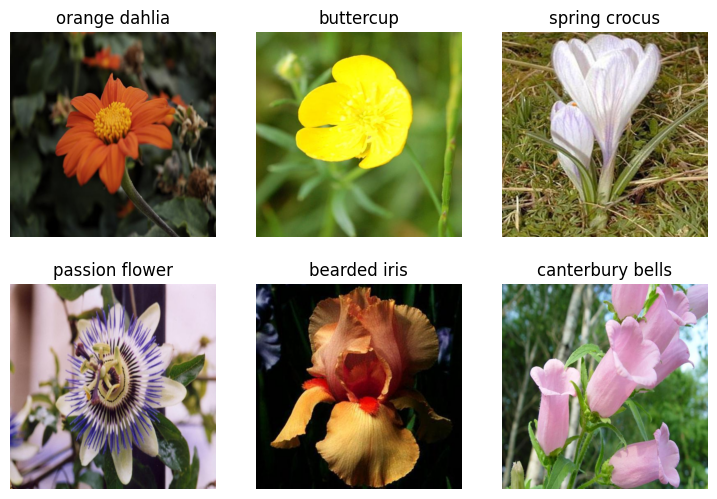

In [13]:
flower_map = pd.read_csv(path/"oxford_flower_102_name.csv")

trn_vld_df['flower_name'] = trn_vld_df['label'].apply(lambda x: flower_map.Name[x])

dls = ImageDataLoaders.from_df(
    trn_vld_df,
    path=path,
    folder='.',
    valid_col='is_valid',
    label_col='flower_name',
    fn_col='fname',
    item_tfms=Resize(500, method="squish")
)

dls.show_batch(max_n=6)

I ran the above a few times and checked that the labels lined up. As far as I can tell they do line up, although I'm not a horticulturist. I guess this proves the value of SMEs and domain expertise!

# Baseline the Model

I've learned that when working with models like this, we want to get a baseline so we can see how any tinkering to the training improves performance. I'm going to do this as simply as I can, just to get a starting point accuracy value. I'm starting with resnet 26 because it should train a bit faster, which allows me to iterate more quickly. Once I get a sense of some of the best parameters and transforms I'll run it with the full resnet50

In [14]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0014454397605732083, slide=0.002511886414140463)

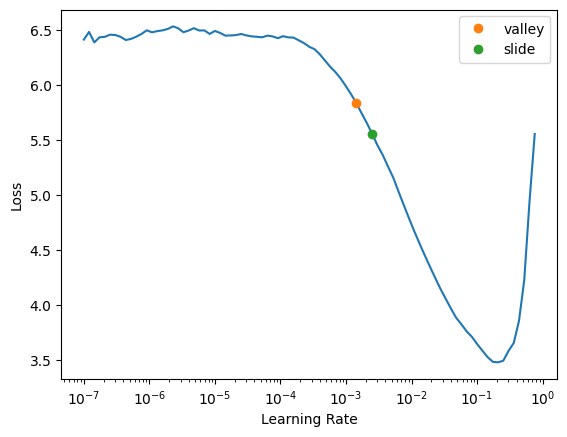

In [15]:
learn.lr_find(suggest_funcs=(valley, slide))


It looks like the slope of the learning rate graph is steepest around .01, so I'll try that for my first learning rate. I should also mention I'm doing this on my personal machine with a 3090, so I have to be extra careful about VRAM usage. I'll save the learner as a pkl file so I can keep track of my models without holding them all in memory.

In [16]:
learn.fine_tune(4, 0.01)
learn.export("flowers_baseline.pkl")

epoch,train_loss,valid_loss,error_rate,time
0,4.356567,2.474855,0.564706,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.922473,1.532441,0.380392,00:09
1,0.727341,1.072898,0.261765,00:09
2,0.484771,0.996256,0.253922,00:09
3,0.336363,0.990108,0.243137,00:09


Not great, but decent for a first attempt. Seems like we can only predict around 75% of the images correctly. Let's determine our actual performance rate on the test set now. 

Typically I wouldn't jump directly to the test set, and I'd play around more with the training and validation sets. At this point, I'm using the test set in the same way I would use submitting to the kaggle leaderboard. It will give me a baseline and help me know if I start getting off track later on. 

Test loss: 1.097
Test error rate: 0.270


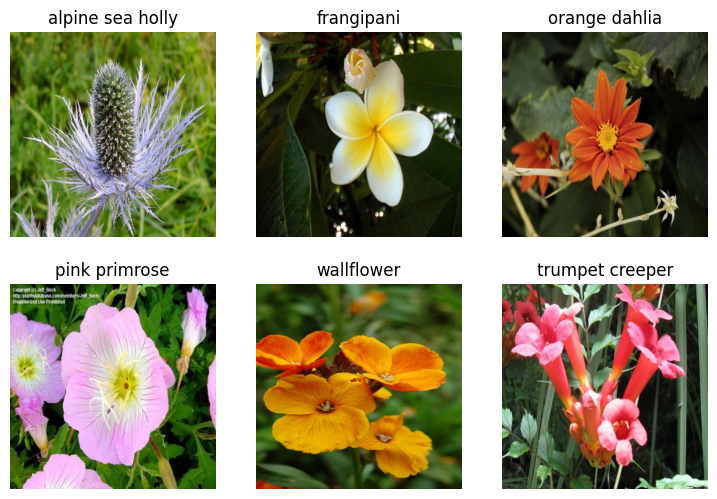

In [17]:
test_df['flower_name'] = test_df['label'].apply(lambda x: flower_map.Name[x])
test_dl = dls.test_dl(test_df, with_labels=True)

# Now validate
loss, *metrics = learn.validate(dl=test_dl)

print(f"Test loss: {loss:.3f}")
print(f"Test error rate: {metrics[0]:.3f}")

test_dl.show_batch(max_n=6)

Ok great. That result makes sense. When we applied our learner to the test dataset we got a result that was slightly worse. Of course we did. The test set has around 6k images, whereas our training set only has around 1k. The rest of this notebook will be dedicated to improving our baseline metrics. But first, I'll just wrap the above code into a function to make verification easier.

In [18]:
import torch

def verify_learner(learner):
    # Now validate
    loss, *metrics = learner.validate(dl=test_dl)

    print(f"Test loss: {loss:.3f}")
    print(f"Test error rate: {metrics[0]:.3f}")

del learn
torch.cuda.empty_cache()

# Optimizing the Model

I am pretty much going to run through a subset of the data optimizations in the notebook I linked above

I guess I'll try making the images smaller to see if I can make the training loop faster. This should get us to a faster training time and not impact the accuracy too much. We just want to get in the ballpark of our accuracy from our last training so we can iterate more quickly.

In [20]:
small_pth = path/"smaller"/"jpg"

In [21]:
resize_images(path/'jpg', dest=small_pth, max_size=256, recurse=True)


In [22]:
def train(arch, item, batch, epochs=5, folder = ''):
    lr = 0.01
    dls = ImageDataLoaders.from_df(
        trn_vld_df,
        path=path,
        folder='.' + folder,
        valid_col='is_valid',
        label_col='flower_name',
        fn_col='fname',
        item_tfms=item,
        batch_tfms=batch
    )
    dls.show_batch(max_n=3)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, lr)
    return learn

epoch,train_loss,valid_loss,error_rate,time
0,4.618897,2.725442,0.491176,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.607633,1.553987,0.378431,00:02
1,1.386632,1.469676,0.359804,00:02
2,1.071519,1.385503,0.327451,00:02
3,0.823332,1.307878,0.314706,00:02
4,0.658670,1.292491,0.309804,00:02


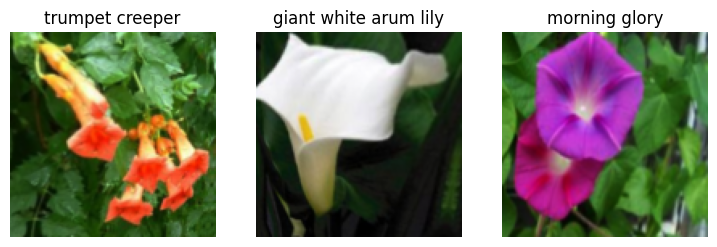

In [23]:
learn = train('resnet26d', item=Resize(192, method="squish"),
              batch=aug_transforms(size=128, min_scale=0.75), folder="/smaller")

Ok perfect, around what what we got last time with a significant training time reduction.

## Effect of Image Transforms

Now I want to see what happens if I change the image pre-processing. We first "squished" the images, now we'll see how cropping them and padding them affects the results.

epoch,train_loss,valid_loss,error_rate,time
0,4.369109,2.711665,0.475490,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.494434,1.471795,0.369608,00:02
1,1.330196,1.422566,0.329412,00:02
2,1.054390,1.319151,0.317647,00:02
3,0.833957,1.227265,0.292157,00:02
4,0.668740,1.183494,0.290196,00:02


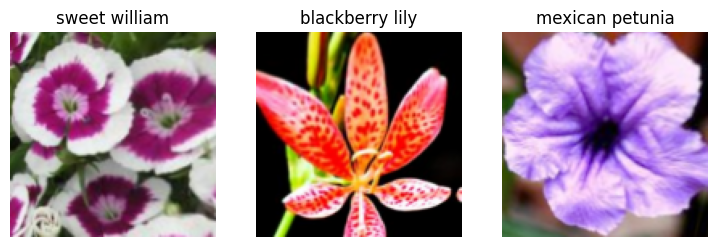

In [24]:
# Crop results
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75), folder="/smaller")

epoch,train_loss,valid_loss,error_rate,time
0,4.652976,2.947920,0.556863,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.831202,1.742645,0.403922,00:02
1,1.585920,1.497415,0.354902,00:02
2,1.272542,1.304852,0.307843,00:02
3,0.995634,1.165755,0.278431,00:02
4,0.790987,1.140745,0.282353,00:02


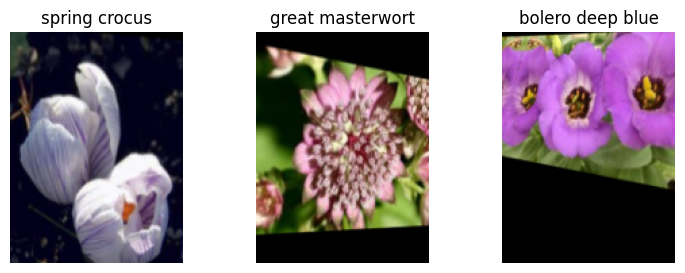

In [25]:
# Pad results
learn = train('resnet26d', item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75), folder = "/smaller")

So our best performance comes from the padding method. We'll keep that for our final model.

## Experimenting with Test Time Augmentation

In [26]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.2824)

We want to show that we can use the above code to get the error rate. We then can use test time augmentation to get the average of the predictions of each of the augmented images and the original image itself. This lets us leverage all of the augmented images into more accurate predictions

In [28]:
tta_preds,_ = learn.tta(dl=valid)
error_rate(tta_preds, targs)

TensorBase(0.2431)

# Final Model

To recap. After loading our data into python, we split it into train/validation/test sets. Then we got a baseline to see where we were starting from and to make sure all of our code so far was in line. We then experimented with a few types of image transforms and test time augmentation. To give us more time, we resized the original image set and used the shrunken images. 

We now want to apply what we've learned to our final model. We want to go back to our original-sized images, use the padding transform, apply TTA, and use the requested model (resnet50). We'll also add a few more epochs to our training for good measure now that we have a sense of what transforms are most effective.

epoch,train_loss,valid_loss,error_rate,time
0,4.892752,2.657414,0.625490,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.828908,2.204603,0.490196,00:05
1,1.463666,1.521940,0.367647,00:05
2,1.162235,1.265880,0.321569,00:05
3,0.963719,1.215181,0.313726,00:06
4,0.788255,1.186825,0.282353,00:05
5,0.645374,1.123951,0.266667,00:05
6,0.514764,0.984290,0.247059,00:05
7,0.408206,0.989627,0.239216,00:05
8,0.331815,0.921819,0.231373,00:05
9,0.280903,0.881507,0.228431,00:05


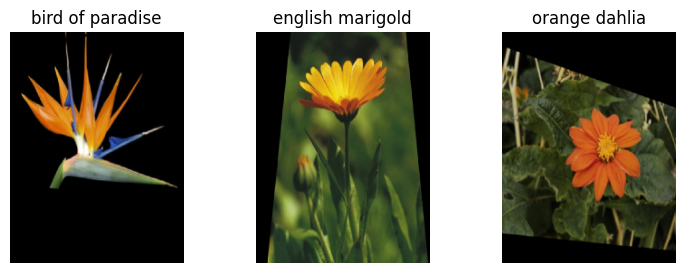

In [29]:
learn = train("resnet50", epochs=12,
              item=Resize((500), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))
learn.export("flower_final.pkl")

In [30]:
test_dl = learn.dls.test_dl(test_df, with_labels=True)
tta_preds, targs = learn.tta(dl=test_dl)

# Now validate
err = error_rate(tta_preds, targs)


In [31]:
err = float(err)
print(f"Test error rate: {err:.4f}")

Test error rate: 0.1960


# Conclusion
Ok, well how did we do? Fortunately we started with a baseline error rate of 0.27 to help us answer that question; which we beat with a final error rate of .196! I consider that successful because its a substantial improvement. I also read the [original paper](https://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) from 2008, which stated their best (SOTA) results were 72.8% accuracy (Or equivalently, a .272 error rate). 

## Furthering Results
I am a bit of a perfectionist, so I like to comment on ways that I think this could be imporved further, but are outside of the time limit and scope (in my opinion)

* I would play around with the image sizes. I pretty arbitralily decided to resize the images to 500x500 pixels because they were all at least that size. There might be a better image resizing method that I'm not aware of.
* One of the constraints of this project was to use the resnet50 model. If I were to try and get better results I would probably try to ensemble the predictions of several models together.
* The fastai version of this dataset did not include the original image segmentations from the research paper. It would be a bit intesive, but my results would probably increase if I incorporated those segmentations into training.
* Speaking of training, why not just combine the validation set and training set into one training set? Technically we just wanted to get good results on the dataset, we don't necessarily need the model to be robust. We could just do it this way, which would double our model's training data and probably give us great results. Definitely a terrible idea if this model ever needed to enter something resembling production though.